## Start

In [1]:
import nrrd

In [2]:
import torch
torch.cuda.set_device(4)

from rsnautils import *
from fastai2.callback.data import *

set_num_threads(1)
nw = 8
pre = 'tcia-ct-segm'

In [3]:
path = Path('~/data/tcia-ct-scan-dataset/nrrds').expanduser()

In [4]:
path_test = path/'test'
path_valid = path/'validation'

In [5]:
path_onc1 = path_test/'oncologist'
path_rad1 = path_test/'radiographer'

In [6]:
path_onc2 = path_valid/'oncologist'
path_rad2 = path_valid/'radiographer'

In [7]:
studies = (path_onc1.ls()+path_onc2.ls())

In [8]:
studies

(#31) [/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/TCGA-CV-7236,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/TCGA-CV-7243,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/0522c0768,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/0522c0479,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/0522c0629,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/0522c0248,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/TCGA-CV-A6JO,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/0522c0845,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/0522c0017,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/test/oncologist/0522c0427...]

In [9]:
path_st = studies[0]

In [10]:
a='a'

In [11]:
path_ra =  Path(str(path_st).replace('oncologist','radiographer'))

In [12]:
path_seg1 = path_st/'segmentations'

In [13]:
lbl_t = path_seg1.ls()
labels = lbl_t.attrgot('name')
labels

(#21) [Spinal-Cord.nrrd,Lens-Lt.nrrd,Brainstem.nrrd,Brain.nrrd,Cochlea-Lt.nrrd,Submandibular-Lt.nrrd,Lacrimal-Lt.nrrd,Orbit-Lt.nrrd,Spinal-Canal.nrrd,Lens-Rt.nrrd...]

In [14]:
ct = path_st/'CT_IMAGE.nrrd'
im,header = nrrd.read(ct)
im.shape

(512, 512, 127)

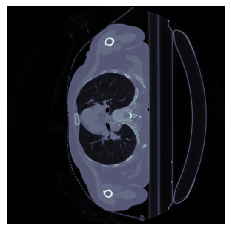

In [15]:
show_image(im[...,0]);

In [16]:
def ct2pkls(fn):
    dest = fn.with_suffix('.dir')
    if dest.name!='CT_IMAGE.dir': return
    dest.mkdir(exist_ok=True)
    im,header = nrrd.read(fn)
    tim = tensor(im).permute(2,0,1).float()
    for i,t in enumerate(tim): TensorCTScan(t).save_jpg(dest/str(i), **brain_args)

In [85]:
# ct2pkls(fns[1])

/home/jhoward/data/tcia-ct-scan-dataset/nrrds/validation/radiographer/0522c0576/segmentations/Spinal-Cord.dir


In [22]:
segs = L(path.glob('**/segmentations'))

In [24]:
dn = segs[0]

In [62]:
dn.parent.ls()

(#3) [/home/jhoward/data/tcia-ct-scan-dataset/nrrds/validation/radiographer/0522c0576/CT_IMAGE.dir,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/validation/radiographer/0522c0576/segmentations,/home/jhoward/data/tcia-ct-scan-dataset/nrrds/validation/radiographer/0522c0576/CT_IMAGE.nrrd]

In [59]:
dn

PosixPath('/home/jhoward/data/tcia-ct-scan-dataset/nrrds/validation/radiographer/0522c0576/segmentations')

In [67]:
def seg2img(dn):
    dest = dn.with_suffix('.dir')
    dest.mkdir(exist_ok=True)
    ll = L(nrrd.read(dn/o)[0].transpose(2,0,1) for o in labels)
    sl = np.stack(tuple(ll), axis=-1)
    sa = sl.argmax(axis=-1).astype(np.byte)
    for i,t in enumerate(sa): torch.save(tensor(t), dest/str(i))

In [74]:
# parallel(seg2img, segs, n_workers=24);

(#62) [None,None,None,None,None,None,None,None,None,None...]

In [81]:
s = torch.load(segs[1].with_suffix('.dir')/'120')

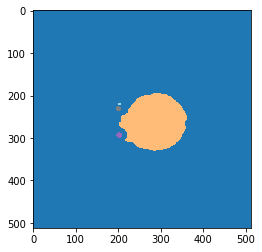

In [82]:
plt.imshow(s, cmap=plt.cm.tab20);

In [88]:
# fns = list(path.glob('**/*.nrrd'))
# parallel(ct2pkls, fns, n_workers=32)

(#1364) [None,None,None,None,None,None,None,None,None,None...]

In [74]:
p = ct.with_suffix('.dir')
# !rm -rf {p}

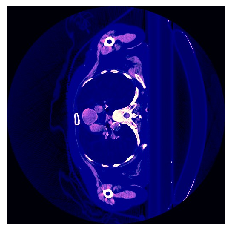

In [75]:
c = p/'0.jpg'
t = PILCTScan.create(c)
TensorCTScan(t).show();